<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numba




* Numba translates Python functions to optimized machine code at runtime using LLVM compiler library
* Numba-compiled numerical algorithms can approach the speeds of C or Fortran, despite being written in basic Python syntax
* Numba is interoperable with NumPy, so NumPy arrays can be used in Numba
* Many NumPy functions are also supported within Numba Functions
* Numba's central features is the `@jit` decorator
* This will mark a function for optimization by Numba's JIT compiler



## Example

Here's a naive implementation of bubble sort in Python.

In [ ]:
from numba import jit, njit
import numpy as np

def bubblesort(X):
    N = len(X)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            cur = X[i]
            if cur > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

Let's do  some tests to get a sense of its performance. In a Jupyter notebook `%timeit` will time a single line. It will exectue the line multitple times. The precise number of times is determined automatically. It will report the mean and standard deviation in timing of each execution.  

In [ ]:
N = 5000
x = np.linspace(0., 1., N)
shuffled = x.copy()
np.random.shuffle(shuffled)
sorted = shuffled.copy()

In [ ]:
# Shuffle and resort the array several times
%timeit sorted[:] = shuffled[:]; bubblesort(sorted)

6.81 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Well, it's pretty slow unfortunately. Here is the same implementation in Numba. Here data types are inferred by Numba and a function with the appropriate type signatures is compiled.

In [ ]:
from numba import jit, njit

@jit
def bubblesort_numba(X):
    N = len(X)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            cur = X[i]
            if cur > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

In [ ]:
%timeit sorted[:] = shuffled[:]; bubblesort_numba(sorted)

21.4 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is considerably faster with no change to the actual code. Just a decorator.

## Data Types

By default, Numba will attempt to infer data types for every operation. If you do not want data types to be inferred by Numba you can specify types explicitly.

In [ ]:
from numba import int32

@jit(int32(int32, int32))
def f(x, y):
    # A somewhat trivial example
    return x + y

In [ ]:
a = 1
b = 2
f(a,b)

3

From the Numba docs, Numba supports a number of types including these common ones:
* `void` is the return type of functions returning nothing (which actually return None when called from Python)

* `int8`, `uint8`, `int16`, `uint16`, `int32`, `uint32`, `int64`, `uint64` are fixed-width integers of the corresponding bit width (signed and unsigned)

* `float32` and `float64` are single- and double-precision floating-point numbers, respectively

* `complex64` and `complex128` are single- and double-precision complex numbers, respectively

* array types can be specified by indexing any numeric type, e.g. `float32[:]` for a one-dimensional single-precision array or `int8[:,:]` for a two-dimensional array of 8-bit integers.



## Composing Functions

Numba-compiled functions can call other compiled functions as well as many NumPy functions.

In [ ]:
import math

@jit
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

@jit
def distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [ ]:
(hypot(3, 4), square(10)), distance(np.array([1, 2]), np.array([3, 4]))

((5.0, 100), 2.8284271247461903)

## Compilation Options
* Numba has two compilation modes, nopython mode and object mode
* In nopython mode, the Numba will generate code that does not access the Python C API
* This yields the highest performance, but requires all native types of values can be inferred
* In object mode, the Numba compiler generates code that handles all values as Python objects and uses the C API to perform operations on those objercts
* This is typically not much faster than standard Python

In [ ]:
import numpy as np
from numba import jit, float32, void

@jit(void(float32[:]), nopython=True)
def bubblesort(X):
    N = len(X)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            if X[i] > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

There is also a shortand decorator for nopython mode `@njit`.

In [ ]:
@njit
def add(x, y):
    return x + y

Certain things don't work in nopython mode such as most things that aren't using primitive data types.

In [ ]:
from numba import njit
from decimal import Decimal

def bubblesort(X):
    N = len(X)
    # This is an issue
    val = Decimal(100)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            cur = X[i]
            if cur > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

## NumPy Universal Functions

* Numba's @vectorize decorator converts scalard functions to NumPy ufuncs
* A ufunc or universal function operates on ndarrays in an element-wise fashion
* They support broadcasting, type casting, and other standard Numpy features

In [ ]:
import numpy as np
from numba import vectorize, int64
@vectorize([int64(int64, int64)])
def vec_add(x, y):
    return x + y

a = np.arange(6, dtype=np.int64)
b = np.linspace(0, 10, 6, dtype=np.int64)
print(vec_add(a, a))
print(vec_add(b, b))

[ 0  2  4  6  8 10]
[ 0  4  8 12 16 20]


## What Works in Numba?

This works well!

In [ ]:
from numba import jit
import numpy as np

x = np.arange(100).reshape(10, 10)

@jit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

print(go_fast(x))

[[  9.  10.  11.  12.  13.  14.  15.  16.  17.  18.]
 [ 19.  20.  21.  22.  23.  24.  25.  26.  27.  28.]
 [ 29.  30.  31.  32.  33.  34.  35.  36.  37.  38.]
 [ 39.  40.  41.  42.  43.  44.  45.  46.  47.  48.]
 [ 49.  50.  51.  52.  53.  54.  55.  56.  57.  58.]
 [ 59.  60.  61.  62.  63.  64.  65.  66.  67.  68.]
 [ 69.  70.  71.  72.  73.  74.  75.  76.  77.  78.]
 [ 79.  80.  81.  82.  83.  84.  85.  86.  87.  88.]
 [ 89.  90.  91.  92.  93.  94.  95.  96.  97.  98.]
 [ 99. 100. 101. 102. 103. 104. 105. 106. 107. 108.]]


This makes Numba sad because it doesn't understand more complex objects.

## A Mental Model for Numba
It can be helpful to have a general conceptual overview of how Numba performs JIT compilation. Roughly speaking the process works like this:

1. You decorate a function (e.g., @njit). Numba doesn't compile immediately (unless you supplied an explicit signature). Instead it creates a dispatcher object that waits for the first call.

2. First call triggers specialization. The dispatcher looks at the argument types (e.g., int64, float64[:]) and either reuses an existing compiled version or builds a new specialization for that exact signature. Future calls with the same types reuse it.

3. Compilation pipeline (per specialization):

  * Typing (type inference): Numba walks your Python AST (Abstract Syntax Tree) / bytecode and assigns Numba types to every value and operation. This either succeeds (pure “nopython” path) or falls back to object mode (much slower, uses Python/C API), or errors if you asked for nopython=True.


  * Lowering to IR and LLVM: The typed IR is lowered to LLVM IR via llvmlite; then LLVM optimizes and emits machine code.
  numba.readthedocs.io

  * Boxing/unboxing boundaries: Values are converted to/from Python objects only at the call boundary (entering/exiting compiled code). In strict nopython, these conversions are minimized/avoided; in object mode they're everywhere.


4. Execution & caching:

  * The compiled machine code is stored in-memory on the dispatcher keyed by signature.

  * If you pass cache=True, Numba also keeps a disk cache (e.g., under __pycache__) so a new Python process can skip recompilation for the same function/signature/options. (Not every function is cacheable.)


In [ ]:
from numba import jit
import pandas as pd

x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

@jit(forceobj=True, looplift=True) # Need to use object mode, try and compile loops!
def use_pandas(a): # Function will not benefit from Numba jit
    df = pd.DataFrame.from_dict(a) # Numba doesn't know about pd.DataFrame
    df += 1                        # Numba doesn't understand what this is
    return df.cov()                # or this!

print(use_pandas(x))

      a      b
a   1.0   10.0
b  10.0  100.0


## Example 1: Mandelbrot Set

* Let's look at an example where Numba shines
* The Mandelbrot set is defined as a two-dimensional set in the complex plane for which the function
$$ f_c(z) = z^2 + c$$
does not diverge to infinity when iterated starting at $z = 0$. Below we have a standard implementation in Python, where for every point on a grid, we perform the this iteration and test for divergence.


In [ ]:
import numpy as np

def mandelbrot_py(xmin, xmax, ymin, ymax, width, height, maxiter):
    result = np.zeros((height, width), dtype=np.int32)
    for j in range(height):
        y0 = ymin + j * (ymax - ymin) / height
        for i in range(width):
            x0 = xmin + i * (xmax - xmin) / width
            x = 0.0
            y = 0.0
            it = 0
            while x*x + y*y <= 4.0 and it < maxiter:
                xt = x*x - y*y + x0
                y = 2.0*x*y + y0
                x = xt
                it += 1
            result[j, i] = it
    return result

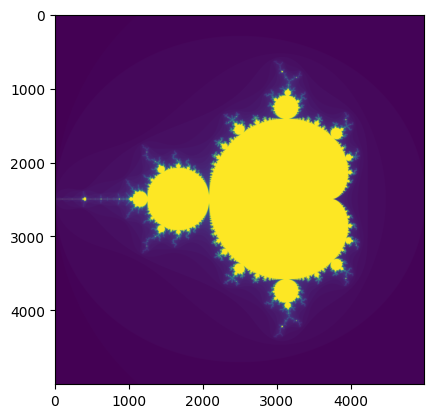

In [ ]:
import matplotlib.pyplot as plt
C = mandelbrot_py(-2.0, 1.0, -1.5, 1.5, 5000, 5000, 100)
plt.imshow(C)

Next, lets look at an example implementation in Numba.

In [ ]:
import numpy as np
from numba import njit

@njit
def mandelbrot_numba(xmin, xmax, ymin, ymax, width, height, maxiter):
    result = np.empty((height, width), np.int32)
    for j in range(height):
        y0 = ymin + j*(ymax-ymin)/height
        for i in range(width):
            x0 = xmin + i*(xmax-xmin)/width
            x = 0.0
            y = 0.0
            it = 0
            while x*x + y*y <= 4.0 and it < maxiter:
                xt = x*x - y*y + x0
                y  = 2.0*x*y + y0
                x  = xt
                it += 1
            result[j, i] = it
    return result

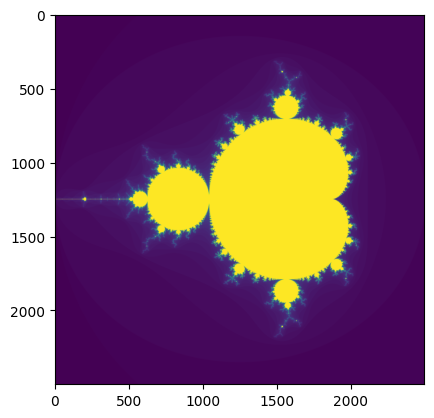

In [ ]:
import matplotlib.pyplot as plt
C = mandelbrot_numba(-2.0, 1.0, -1.5, 1.5, 2500, 2500, 100)
plt.imshow(C)

In [ ]:
import time, statistics as stats

def bench(fn, *args, warmup=True, repeats=5):
    if warmup:
        fn(*args)  # JIT warmup, ignore timing
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn(*args)
        times.append(time.perf_counter() - t0)
    return {
        "median_s": stats.median(times),
        "mean_s": stats.mean(times),
        "min_s": min(times),
        "runs": repeats,
        "all_s": times,
    }

# Problem size
xmin, xmax = -2.0, 1.0
ymin, ymax = -1.5, 1.5
width, height = 1200, 1200
maxiter = 500

# Are the results the same?
ref = mandelbrot_py(xmin, xmax, ymin, ymax, 300, 200, 200)
test = mandelbrot_numba(xmin, xmax, ymin, ymax, 300, 200, 200)
assert np.array_equal(ref, test), "Mismatch between Python and Numba results!"

# Timings
r_py    = bench(mandelbrot_py, xmin, xmax, ymin, ymax, width, height, maxiter, warmup=False)
r_numba = bench(mandelbrot_numba, xmin, xmax, ymin, ymax, width, height, maxiter)

print(f"Pure Python median: {r_py['median_s']*1e3:.1f} ms")
print(f"Numba (CPU,no-par) median: {r_numba['median_s']*1e3:.1f} ms")
print(f"Speedup (Python / Numba): {r_py['median_s']/r_numba['median_s']:.2f}×")

Pure Python median: 21934.7 ms
Numba (CPU,no-par) median: 671.1 ms
Speedup (Python / Numba): 32.68×


## Example 2: Dijkstra's Algorithm

Dijkstra's algorithm is a well known method for computing the shortest distance from a starting node to every other node in a graph.

**Priority Queue**

Because Numba does not support Python objects, implementing some algorithms may require implementing data structures in Numba. For instance, in Dijkstra's algorithm it is efficient to use a priority queue to determine the node with the currently estimated minimum distance to a given vertex.

In [1]:
import numpy as np
from numba import njit

# =========================
# Min-heap (priority queue)
# =========================

@njit(inline='always')
def _swap(heap_nodes, heap_keys, pos, i, j):
    ni = heap_nodes[i]
    heap_nodes[i] = heap_nodes[j]
    heap_nodes[j] = ni
    ki = heap_keys[i]
    heap_keys[i] = heap_keys[j]
    heap_keys[j] = ki
    pos[heap_nodes[i]] = i
    pos[heap_nodes[j]] = j

@njit(inline='always')
def _sift_up(heap_nodes, heap_keys, pos, size, i):
    while i > 0:
        p = (i - 1) // 2
        if heap_keys[i] < heap_keys[p]:
            _swap(heap_nodes, heap_keys, pos, i, p)
            i = p
        else:
            break

@njit(inline='always')
def _sift_down(heap_nodes, heap_keys, pos, size, i):
    while True:
        l = 2 * i + 1
        r = l + 1
        s = i
        if l < size and heap_keys[l] < heap_keys[s]:
            s = l
        if r < size and heap_keys[r] < heap_keys[s]:
            s = r
        if s != i:
            _swap(heap_nodes, heap_keys, pos, i, s)
            i = s
        else:
            break

@njit
def heap_init(capacity, n_nodes):
    """
    Create empty heap arrays.
    capacity: max number of elements to hold in the heap
    n_nodes: size of the universe of node IDs (for pos array)
    Returns: heap_nodes, heap_keys, pos, size
    """
    heap_nodes = np.empty(capacity, dtype=np.int64)
    heap_keys  = np.empty(capacity, dtype=np.float64)
    pos = np.full(n_nodes, -1, dtype=np.int64)
    size = 0
    return heap_nodes, heap_keys, pos, size

@njit
def heap_push(heap_nodes, heap_keys, pos, size, node, key):
    """
    Insert node with priority key. Returns new size.
    Precondition: node not already in heap (pos[node] == -1)
    """
    idx = size
    size += 1
    heap_nodes[idx] = node
    heap_keys[idx]  = key
    pos[node] = idx
    _sift_up(heap_nodes, heap_keys, pos, size, idx)
    return size

@njit
def heap_decrease_key(heap_nodes, heap_keys, pos, size, node, newkey):
    """
    Decrease priority of existing node and restore heap property.
    """
    i = pos[node]
    heap_keys[i] = newkey
    _sift_up(heap_nodes, heap_keys, pos, size, i)

@njit
def heap_pop(heap_nodes, heap_keys, pos, size):
    """
    Pop and return (node, key, new_size) with minimum key.
    Precondition: size > 0
    """
    node = heap_nodes[0]
    key  = heap_keys[0]
    last = size - 1
    # move last to root
    heap_nodes[0] = heap_nodes[last]
    heap_keys[0]  = heap_keys[last]
    pos[heap_nodes[0]] = 0
    pos[node] = -1
    size = last
    if size > 0:
        _sift_down(heap_nodes, heap_keys, pos, size, 0)
    return node, key, size

@njit
def heap_contains(pos, node):
    return pos[node] != -1

@njit
def heap_empty(size):
    return size == 0

Let's try this out and make sure it works.

In [2]:
@njit
def demo():
    # universe of nodes = 8 (IDs 0..7), heap capacity = 8
    heap_nodes, heap_keys, pos, size = heap_init(capacity=8, n_nodes=8)

    # push a few (node, key)
    size = heap_push(heap_nodes, heap_keys, pos, size, 3, 5.0)
    size = heap_push(heap_nodes, heap_keys, pos, size, 1, 7.5)
    size = heap_push(heap_nodes, heap_keys, pos, size, 6, 2.0)
    size = heap_push(heap_nodes, heap_keys, pos, size, 4, 9.0)

    # decrease key of node 1 from 7.5 -> 1.5
    heap_decrease_key(heap_nodes, heap_keys, pos, size, 1, 1.5)

    # pop all, returning nodes in ascending key order: 1, 6, 3, 4
    out_nodes = np.empty(size, dtype=np.int64)
    out_keys  = np.empty(size, dtype=np.float64)
    k = 0
    while not heap_empty(size):
        node, key, size = heap_pop(heap_nodes, heap_keys, pos, size)
        out_nodes[k] = node
        out_keys[k]  = key
        k += 1
    return out_nodes, out_keys

# Run once to compile and see result
nodes, keys = demo()
print("order:", nodes)       # expected: [1, 6, 3, 4]
print("keys :", keys)        # expected: [1.5, 2.0, 5.0, 9.0]

order: [1 6 3 4]
keys : [1.5 2.  5.  9. ]


**CSR Graph Representation**

One complexity that arises in Numba is that it forces you to think in terms of arrays and primitive data types rather than in object oriented terms which can make code more difficult to decipher. While it might be natural to represent a graph in terms of node and edge objects, these aren't supported in Numba. Hence, we need a simple array based representation of a graph for Dijkstra's algorithm. In particular we'll use a CSR (Compressed Sparse Row) matrix to store the graph adjacency matrix.

For convenience we'll start with a standard representation of a graph as a list of tuples. The first element in each tuple is the id of the first node in the edge, the second element is the id of the second node in the edge, and the last element is its weight.

In [10]:
# Example graph
n = 6
edges = [
    (0, 1, 7.0),
    (0, 2, 9.0),
    (0, 5, 14.0),
    (1, 2, 10.0),
    (1, 3, 15.0),
    (2, 3, 11.0),
    (2, 5, 2.0),
    (3, 4, 6.0),
    (4, 5, 9.0)
]

# To make this undirected, well make sure if i is connected to v
# then v is connected to i
undirected = []
for (a,b,w) in edges:
    undirected.append((a,b,w))
    undirected.append((b,a,w))
print(undirected)

[(0, 1, 7.0), (1, 0, 7.0), (0, 2, 9.0), (2, 0, 9.0), (0, 5, 14.0), (5, 0, 14.0), (1, 2, 10.0), (2, 1, 10.0), (1, 3, 15.0), (3, 1, 15.0), (2, 3, 11.0), (3, 2, 11.0), (2, 5, 2.0), (5, 2, 2.0), (3, 4, 6.0), (4, 3, 6.0), (4, 5, 9.0), (5, 4, 9.0)]


Here's a plot of the simple graph we created.

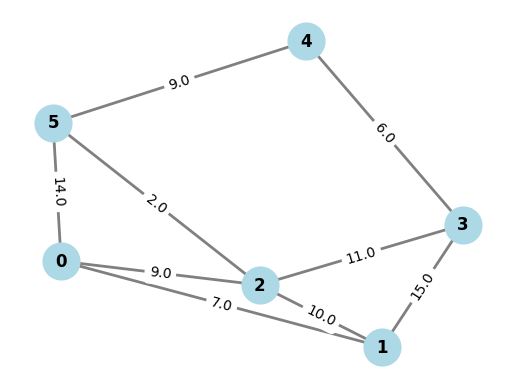

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the edges
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, width=2, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

# Draw edge weights as labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.axis("off")
plt.show()

Now we'll define a function that converts from this tuple based representation to a CSR sparse matrix representation. The CSR representation is illustrated here:

<figure>
<center>
<img src='https://www.researchgate.net/publication/274379571/figure/fig11/AS:669387669401600@1536605865012/A-sparse-matrix-and-its-corresponding-CSR-row-pointer-column-indices-and-values-arrays.png' />
<figcaption>Image Caption</figcaption></center>
</figure>
For each row, the row pointer array (also called indptr) points to the a starting index in the column indices array. Starting with this index, indices stores the column indices of each non-zero value in the corresponding row, while the corresponding spot in the values array stores the nonzero value stored in that row index, column index pair.

To represent a graph, we start with its edge-weighted adjacency matrix.

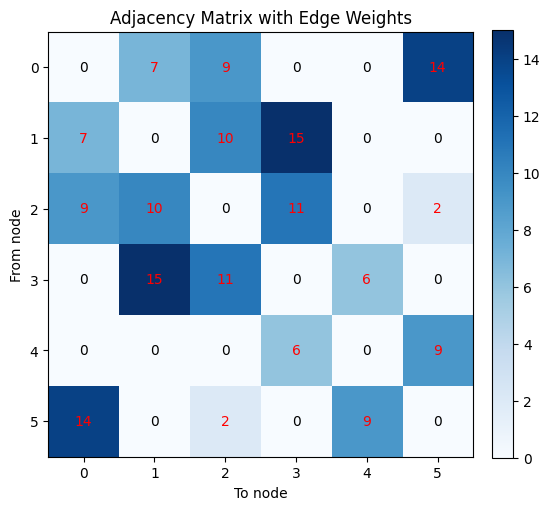

In [16]:
# This code just builds and plot the edge weighted adjacency matrix
adj = np.zeros((n, n))
for u, v, w in edges:
    adj[u, v] = w
    adj[v, u] = w

# Plot adjacency matrix with labels
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(adj, cmap="Blues")

# Label each cell with weight (0 if no edge)
for i in range(n):
    for j in range(n):
        text = f"{adj[i, j]:.0f}"
        ax.text(j, i, text,
                ha="center", va="center",
                color="black" if adj[i, j] == 0 else "red",
                fontsize=10)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels([str(i) for i in range(n)])
ax.set_yticklabels([str(i) for i in range(n)])
ax.set_xlabel("To node")
ax.set_ylabel("From node")
ax.set_title("Adjacency Matrix with Edge Weights")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

This utility function encodes the edge-weighted adjacency matrix in CSR format.

In [31]:
def edges_to_csr(n, edges):
    edges = np.asarray(edges, dtype=np.float64)
    # From index
    u = edges[:, 0].astype(np.int64)
    # To Index
    v = edges[:, 1].astype(np.int64)
    # Weights
    w = edges[:, 2].astype(np.float64)
    # Get the degrees of all nodes
    _, deg = np.unique(u, return_counts=True)


    indptr = np.zeros(n + 1, dtype=np.int64)
    np.cumsum(deg, out=indptr[1:])
    m = len(u)
    indices = np.empty(m, dtype=np.int64)
    weights = np.empty(m, dtype=np.float64)

    fill = indptr.copy()
    for i in range(m):
        x = u[i]
        k = fill[x]
        indices[k] = v[i]
        weights[k] = w[i]
        fill[x] += 1

    return indptr, indices, weights

And here here's the resulting CSR representation for the example graph.

In [33]:
indptr, indices, weights = edges_to_csr(n, undirected)
print("indptr:", indptr)
print("indices:", indices)
print("weights:", weights)

indptr: [ 0  3  6 10 13 15 18]
indices: [1 2 5 0 2 3 0 1 3 5 1 2 4 3 5 0 2 4]
weights: [ 7.  9. 14.  7. 10. 15.  9. 10. 11.  2. 15. 11.  6.  6.  9. 14.  2.  9.]


Now that we've covered how to represent a graph using CSR and have an implementation of a priority queue, we can move on to implementing Dijkstra's algorithm in Numba.

In [36]:
@njit
def dijkstra_csr_numba(n, indptr, indices, weights, src):
    """
    Run Dijkstra's algorithm on a graph in CSR format.

    Parameters
    ----------
    n : int
        Number of nodes.
    indptr, indices, weights : arrays
        CSR representation of the adjacency matrix:
          - neighbors of node u are indices[indptr[u]:indptr[u+1]]
          - corresponding weights are weights[indptr[u]:indptr[u+1]]
    src : int
        Source node.

    Returns
    -------
    dist : float[n]
        Shortest distances from src to all nodes.
    parent : int[n]
        Predecessor of each node on the shortest path (-1 if none).
    """
    INF = 1e300
    dist = np.full(n, INF, dtype=np.float64)   # distance estimates
    parent = np.full(n, -1, dtype=np.int64)    # to reconstruct paths
    visited = np.zeros(n, dtype=np.uint8)      # mark finalized nodes

    dist[src] = 0.0

    # Initialize min-heap with just the source node
    heap_nodes, heap_keys, pos, size = heap_init(n, n)
    size = heap_push(heap_nodes, heap_keys, pos, size, src, 0.0)

    # Main loop: extract min, relax neighbors
    while not heap_empty(size):
        u, uk, size = heap_pop(heap_nodes, heap_keys, pos, size)
        if visited[u]:
            continue
        visited[u] = 1

        du = dist[u]

        # Relax all edges u -> v
        start = indptr[u]
        end = indptr[u + 1]
        for k in range(start, end):
            v = indices[k]
            if visited[v]:
                continue
            nd = du + weights[k]    # tentative new distance
            if nd < dist[v]:
                dist[v] = nd
                parent[v] = u
                if pos[v] == -1:
                    # Node not yet in heap → insert
                    size = heap_push(heap_nodes, heap_keys, pos, size, v, nd)
                else:
                    # Node already in heap → decrease-key
                    heap_decrease_key(heap_nodes, heap_keys, pos, size, v, nd)

    return dist, parent

In [47]:
dist, parent = dijkstra_csr_numba(n, indptr, indices, weights, 0)

In [48]:
dist, parent

(array([ 0.,  7.,  9., 20., 20., 11.]), array([-1,  0,  0,  2,  5,  2]))

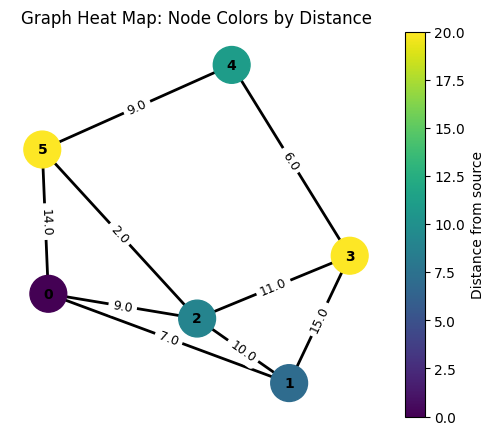

In [49]:
G = nx.Graph()
G.add_weighted_edges_from(edges)


# Layout
pos = nx.spring_layout(G, seed=42)

# Node colors based on distance
cmap = plt.cm.viridis  # color map
vmin, vmax = min(dist), max(dist)

plt.figure(figsize=(6, 5))

# Draw nodes → save handle for colorbar
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=700,
    node_color=dist,
    cmap=cmap,
    vmin=vmin, vmax=vmax
)
nx.draw_networkx_edges(G, pos, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

cbar = plt.colorbar(nodes)
cbar.set_label("Distance from source")

plt.title("Graph Heat Map: Node Colors by Distance")
plt.axis("off")
plt.show()